## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt
from os import path

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.models import OrdinaryLFM, MultiOutputGP, generate_multioutput_rbf_gp
from lafomo.plot import Plotter, Colours
from lafomo.trainers import VariationalTrainer, ParameterPreEstimator
from lafomo.utilities.data import p53_ground_truth

Let's start by importing our dataset...

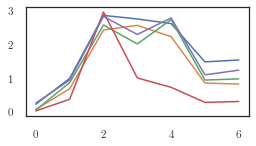

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data')
num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])

We use the ordinary differential equation (ODE):

`dy/dt = b + sf(t) - dy`

`f(t) ~ GP(0, k(t, t'))`

Since this is an ODE, we inherit from the `OrdinaryLFM` class.

In [3]:
from gpytorch.constraints import Positive
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.raw_decay = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_basal = Parameter(0.5 * torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_sensitivity = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def basal_rate(self):
        return self.positivity.transform(self.raw_basal)

    @basal_rate.setter
    def basal_rate(self, value):
        self.raw_basal = self.positivity.inverse_transform(value)

    @property
    def sensitivity(self):
        return self.positivity.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.raw_sensitivity = self.decay_constraint.inverse_transform(value)

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        f = self.f
        if not self.pretrain_mode:
            f = self.f[:, :, self.t_index].unsqueeze(2)
            if t > self.last_t:
                self.t_index += 1
            self.last_t = t

        dh = self.basal_rate + self.sensitivity * f - self.decay_rate * h
        return dh

In [20]:
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    num_samples=80,
    initial_conditions=False
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, 14, 80, dtype=torch.float32)
step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = True
gp_model = generate_multioutput_rbf_gp(num_tfs, inducing_points, gp_kwargs=dict(natural=use_natural))

lfm = TranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)
plotter = Plotter(lfm, dataset.gene_names, style='seaborn')

In [21]:
class P53ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        with torch.no_grad():
            sens = torch.tensor(1.)
            dec = torch.tensor(0.8)
            self.lfm.raw_sensitivity[3] = self.lfm.positivity.inverse_transform(sens)
            self.lfm.raw_decay[3] = self.lfm.positivity.inverse_transform(dec)
        super().after_epoch()

track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.05)
    optimizers = [variational_optimizer, parameter_optimizer]
    pre_variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    pre_parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.005)
    pre_optimizers = [pre_variational_optimizer, pre_parameter_optimizer]

else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]
    pre_optimizers = [Adam(lfm.parameters(), lr=0.05)]
trainer = P53ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)
pre_estimator = ParameterPreEstimator(lfm, pre_optimizers, dataset, track_parameters=track_parameters)

### Outputs prior to training:

Text(0.5, 1.0, 'Latent')

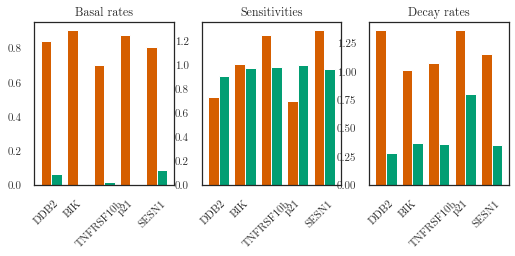

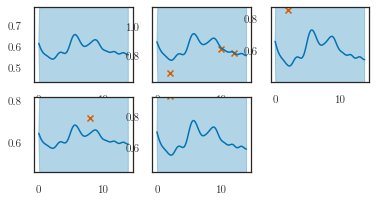

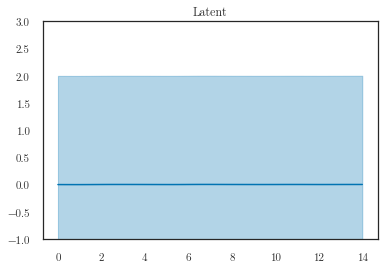

In [22]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')

In [27]:
lfm.pretrain(True)
lfm.loss_fn.num_data = 61
pre_estimator.train(50, report_interval=20)

Epoch 401/600 - Loss: 1.50 (1.10 0.40) kernel: [[[1.0781624]]]
Epoch 421/600 - Loss: 1.25 (0.85 0.41) kernel: [[[1.0859731]]]
Epoch 441/600 - Loss: 0.98 (0.57 0.41) kernel: [[[1.0909587]]]
Epoch 461/600 - Loss: 0.72 (0.30 0.42) kernel: [[[1.0970062]]]
Epoch 481/600 - Loss: 0.48 (0.05 0.43) kernel: [[[1.1055425]]]
Epoch 501/600 - Loss: 0.24 (-0.20 0.44) kernel: [[[1.1089844]]]
Epoch 521/600 - Loss: -0.02 (-0.47 0.45) kernel: [[[1.1158359]]]
Epoch 541/600 - Loss: -0.28 (-0.74 0.46) kernel: [[[1.1213778]]]
Epoch 561/600 - Loss: -0.53 (-1.00 0.46) kernel: [[[1.1267926]]]
Epoch 581/600 - Loss: -0.77 (-1.24 0.47) kernel: [[[1.1291584]]]


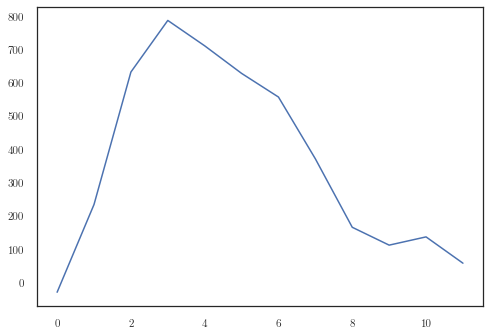

In [28]:
ind = lfm.gp_model
if use_natural:
    ind = dict(ind.named_parameters())['variational_strategy.base_variational_strategy._variational_distribution.natural_vec'].detach()
else:
    ind = dict(ind.named_parameters())['variational_strategy.base_variational_strategy._variational_distribution.variational_mean'].detach()
plt.plot(ind.squeeze())

In [29]:
lfm.pretrain(False)
lfm.loss_fn.num_data = num_training
step_size = 5e-1
trainer.train(300, report_interval=10, step_size=step_size)

Epoch 001/300 - Loss: 17.15 (12.96 4.19) kernel: [[[1.100602]]]
Epoch 011/300 - Loss: 14.77 (11.43 3.34) kernel: [[[0.820094]]]
Epoch 021/300 - Loss: 7.95 (5.28 2.67) kernel: [[[0.66356975]]]
Epoch 031/300 - Loss: 5.82 (3.68 2.14) kernel: [[[0.59247595]]]
Epoch 041/300 - Loss: 5.03 (3.25 1.78) kernel: [[[0.5729946]]]
Epoch 051/300 - Loss: 4.61 (2.99 1.63) kernel: [[[0.58856285]]]
Epoch 061/300 - Loss: 4.27 (2.72 1.55) kernel: [[[0.6195599]]]
Epoch 071/300 - Loss: 4.17 (2.64 1.53) kernel: [[[0.6530933]]]
Epoch 081/300 - Loss: 3.90 (2.37 1.53) kernel: [[[0.68315345]]]
Epoch 091/300 - Loss: 3.78 (2.22 1.56) kernel: [[[0.7117961]]]
Epoch 101/300 - Loss: 3.48 (1.91 1.57) kernel: [[[0.7343901]]]
Epoch 111/300 - Loss: 3.40 (1.78 1.61) kernel: [[[0.75228435]]]
Epoch 121/300 - Loss: 3.20 (1.55 1.65) kernel: [[[0.77300876]]]
Epoch 131/300 - Loss: 3.08 (1.39 1.69) kernel: [[[0.7889337]]]
Epoch 141/300 - Loss: 2.86 (1.14 1.72) kernel: [[[0.8007512]]]
Epoch 151/300 - Loss: 2.71 (0.95 1.77) kernel: 

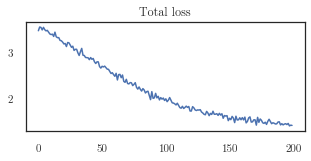

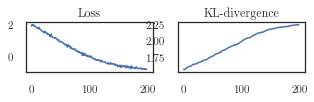

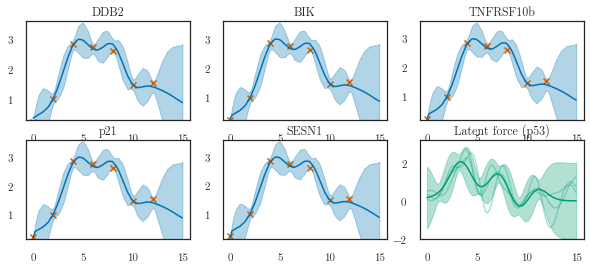

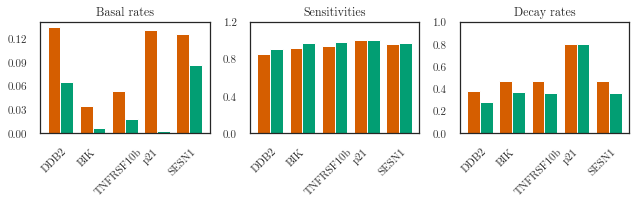

In [30]:
tight_kwargs = dict(bbox_inches='tight', pad_inches=0)
t_predict = torch.linspace(0, 15, 80, dtype=torch.float32)

lfm.eval()
q_m = lfm.predict_m(t_predict, step_size=step_size)
q_f = lfm.predict_f(t_predict)

plotter.plot_losses(trainer, last_x=200)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))

row = 0
col = 0
for i in range(num_genes):
    if i == 3:
        row += 1
        col = 0
    ax = axes[row, col]
    plotter.plot_gp(q_m, t_predict, replicate=0, ax=ax,
                    color=Colours.line_color, shade_color=Colours.shade_color,
                    t_scatter=dataset.t_observed, y_scatter=dataset.m_observed, num_samples=0)
    col += 1
    ax.set_title(dataset.gene_names[i])
plotter.plot_gp(q_f, t_predict, ax=axes[1, 2],
                ylim=(-2, 3.2),
                num_samples=3,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color)
axes[1, 2].set_title('Latent force (p53)')
plt.savefig('./combined.pdf', **tight_kwargs)

labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth(),
                        figsize=(9, 3),
                        yticks=[
                            np.linspace(0, 0.12, 5),
                            np.linspace(0, 1.2, 4),
                            np.arange(0, 1.1, 0.2),
                        ])
plt.tight_layout()
plt.savefig('./kinetics.pdf', **tight_kwargs)

In [ ]:
 # key in ['basal_rate', 'sensitivity', 'decay_rate']:
plt.plot(lfm.positivity.transform(torch.stack(trainer.parameter_trace['raw_basal'])[:, 3]))
plt.tight_layout()

In [ ]:
print(lfm.basal_rate)